In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats
 
from sklearn import svm
import sklearn.preprocessing
from sklearn.decomposition import PCA

In [2]:
#read the consolidated data file

fname = 'hotspots_with_average_sensors_data'
data = pd.read_csv(fname+".csv")
# print(data.columns)
data.head()

,datetime,latitude,longitude,ta,wd,ws,rh,fsd
0,2015-01-01 01:00:00,-37.9,145.3,17.39458,112.645153,2.538481,79.370460,253.944641
1,2015-01-01 01:00:00,-32.1,115.9,22.10339,194.336502,4.459360,52.160203,351.146603
2,2015-01-01 02:00:00,-31.9,115.9,22.10339,194.336502,4.459360,52.160203,351.146603
3,2015-01-01 02:00:00,-31.9,115.9,22.10339,194.336502,4.459360,52.160203,351.146603
4,2015-01-01 02:00:00,-31.8,115.8,22.10339,194.336502,4.459360,52.160203,351.146603


In [3]:
# get the variables - all columns without latitude, longitude and time
X_raw=data.as_matrix()
X_raw= X_raw[:,3:]

#take a look at it
print(X_raw.shape)

(12267, 5)


In [4]:
# X_raw= X_raw[:1000,1:-1]

In [5]:
###### pca - dimention reduction to two dimentian 
pca = PCA(n_components=2)
X=pca.fit_transform(X_raw)

#take a look after pca
print(X[:4,:])

[[  40.45350813   17.38145378]
 [  -2.27084475 -104.78279166]
 [  -2.27084475 -104.78279166]
 [  -2.27084475 -104.78279166]]


In [6]:
# we will mark the oddest 0.1% of entries as anomalies
outliers_fraction=0.001
model=svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,  kernel="rbf", gamma=0.1).fit(X)
print(model)


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.05095, random_state=None, shrinking=True,
      tol=0.001, verbose=False)


In [7]:
#predicted score of a point NOT being an outlier
y_pred = model.decision_function(X).ravel()


In [8]:
##potentially we can let user to change the treshhold
threshold = stats.scoreatpercentile(y_pred,100 * outliers_fraction)
print(threshold)

-0.000480528529984


In [9]:
y_pred = y_pred <= threshold
# print(y_pred)

In [10]:
#save original data and a flag=1 if the point is an outlier
X_new = np.c_[X, y_pred]
# print(min(X[:,1]))
print(X_new[:5, :])

[[  40.45350813   17.38145378    0.        ]
 [  -2.27084475 -104.78279166    0.        ]
 [  -2.27084475 -104.78279166    0.        ]
 [  -2.27084475 -104.78279166    0.        ]
 [  -2.27084475 -104.78279166    0.        ]]


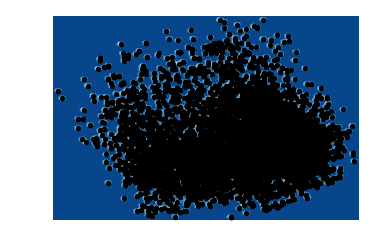

In [11]:
#plotting the stuff
marg=5
xx, yy = np.meshgrid(np.linspace(min(X[:,0])-marg, max(X[:,0])+marg, 500), np.linspace(min(X[:,1])-marg, max(X[:,1])+marg, 500))
Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure()

#contour lines for outlier detection
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')

#scatterplot of the data

plt.scatter(X_new[X_new[:, 2] == 1][:, 0], X_new[X_new[:, 2] == 1][:, 1], color='red', label='outliers')
plt.scatter(X_new[X_new[:, 2] == 0][:, 0], X_new[X_new[:, 2] == 0][:, 1], color='black', label='inliers')
plt.axis('off')
plt.show()

In [12]:
#add a column with outlier flag ot the data
data['outlier']=X_new[:, 2].astype(int)
data.head()

,datetime,latitude,longitude,ta,wd,ws,rh,fsd,outlier
0,2015-01-01 01:00:00,-37.9,145.3,17.39458,112.645153,2.538481,79.370460,253.944641,0
1,2015-01-01 01:00:00,-32.1,115.9,22.10339,194.336502,4.459360,52.160203,351.146603,0
2,2015-01-01 02:00:00,-31.9,115.9,22.10339,194.336502,4.459360,52.160203,351.146603,0
3,2015-01-01 02:00:00,-31.9,115.9,22.10339,194.336502,4.459360,52.160203,351.146603,0
4,2015-01-01 02:00:00,-31.8,115.8,22.10339,194.336502,4.459360,52.160203,351.146603,0


In [13]:
#convert output to json and save it
output=data.to_json(orient="records")

f = open('website_data.js', 'w')
f.write('var data = ' + output + ";")
f.close()

